# Predict the Online News Popularity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset Preparation

In [2]:
df = pd.read_csv("OnlineNewsPopularity-clean.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39626 entries, 0 to 39625
Data columns (total 64 columns):
Unnamed: 0                       39626 non-null int64
url                              39626 non-null object
timedelta                        39626 non-null float64
n_tokens_title                   39626 non-null float64
n_tokens_content                 39626 non-null float64
n_unique_tokens                  39626 non-null float64
n_non_stop_words                 39626 non-null float64
n_non_stop_unique_tokens         39626 non-null float64
num_hrefs                        39626 non-null float64
num_self_hrefs                   39626 non-null float64
num_imgs                         39626 non-null float64
num_videos                       39626 non-null float64
average_token_length             39626 non-null float64
num_keywords                     39626 non-null float64
data_channel_is_lifestyle        39626 non-null float64
data_channel_is_entertainment    39626 non-null float6

### Add popuparity column

Articles with more than 6500 shares are consider popular. To predict the popularity, we need to label the data with if popular with 1 and 0. 

In [4]:
df.loc[(df.shares >6200), 'popularity'] = 1
df.loc[(df.shares <= 6200), 'popularity'] = 0

In [5]:
df.popularity.value_counts()

0.0    35697
1.0     3929
Name: popularity, dtype: int64

## Machine Learning Models Evaluation

### split train and test data

In [6]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score

In [7]:
# select X dataset and y dataset
X = df.iloc[:,2:61]
y = df.popularity

In [8]:
X.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

In [9]:
# split train data and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=21,stratify=y)

### K-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier

#### Search for optimized parameter and train model with optimzed parameter

In [40]:
#train KNeighbors model

param_grid={'n_neighbors':np.arange(1,30)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
print(knn_cv.best_params_,knn_cv.best_score_)

{'n_neighbors': 22} 0.9008580286970942


In [10]:
# The optimized n_neighbors is 22

In [23]:
%%time
# Train KNN model

knn=KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train,y_train)

CPU times: user 233 ms, sys: 4.06 ms, total: 237 ms
Wall time: 244 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                     weights='uniform')

In [24]:
# prediect the test data with trained model

y_predict_knn=knn.predict(X_test)

#### Accuracy Score

In [25]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_predict_knn,y_test)
print('The accuracy score is '+str(score))

The accuracy score is 0.9008243606998654


#### Confusion metrics

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

confusion_knn=confusion_matrix(y_predict_knn,y_test)
classifiction_knn=classification_report(y_predict_knn,y_test)

print('Confusion matrix:\n',confusion_knn)
print('Classifiction report:\n',classifiction_knn)

Confusion matrix:
 [[10709  1179]
 [    0     0]]
Classifiction report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     11888
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90     11888
   macro avg       0.50      0.45      0.47     11888
weighted avg       1.00      0.90      0.95     11888



/Users/elisechen/anaconda3/envs/snowfakes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


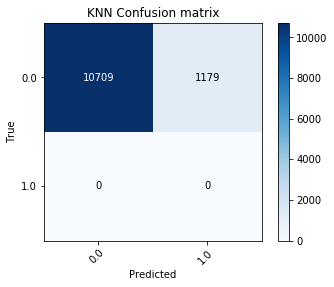

In [27]:
# plot comfusion matrix

from sklearn.utils.multiclass import unique_labels

fig, ax = plt.subplots()
im = ax.imshow(confusion_knn, interpolation='nearest',cmap="Blues")
ax.figure.colorbar(im, ax=ax)
classes = unique_labels(y_predict_knn,y_test)
ax.set(xticks=np.arange(confusion_knn.shape[1]),yticks=np.arange(confusion_knn.shape[0]),xticklabels=classes, yticklabels=classes, title='KNN Confusion matrix', ylabel='True',xlabel='Predicted')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = confusion_knn.max() / 2
for i in range(confusion_knn.shape[0]):
        for j in range(confusion_knn.shape[1]):
            ax.text(j, i, format(confusion_knn[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_knn[i, j] > thresh else "black")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

#### ROC Curve and AUC

In [30]:
from sklearn.metrics import roc_curve,auc

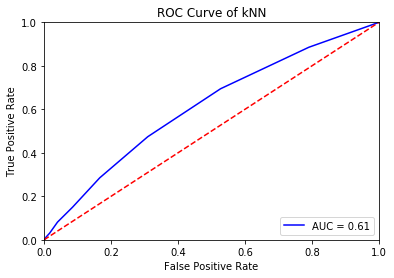

In [31]:
y_scores_knn = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_knn[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

#### Precision-Recall curve

/Users/elisechen/anaconda3/envs/snowfakes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


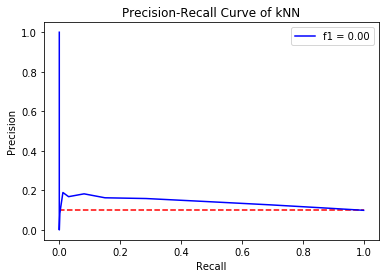

In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn[:, 1])
f1_knn, auc_knn = f1_score(y_test, y_predict_knn), auc(recall_knn, precision_knn)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall_knn, precision_knn,c='b',label = 'f1 = %0.2f' % f1_knn)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve of kNN')
# show the plot
plt.show()

### Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

#### Train the model

In [90]:
%%time
#train Logistic Regression 

gnb = GaussianNB()
gnb.fit(X_train,y_train)


CPU times: user 60.4 ms, sys: 16.6 ms, total: 76.9 ms
Wall time: 85.8 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_predict_gnb = gnb.predict(X_test)

#### Accuracy Score

In [57]:
gnb_score=accuracy_score(y_test,y_predict_gnb)
print(gnb_score)

0.8776917900403769


#### Confusion metrics

In [58]:
confusion_gnb=confusion_matrix(y_predict_gnb,y_test)
classifiction_gnb=classification_report(y_predict_gnb,y_test)

print('Confusion matrix:\n',confusion_gnb)
print('Classifiction report:\n',classifiction_gnb)

Confusion matrix:
 [[10336  1081]
 [  373    98]]
Classifiction report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.93     11417
         1.0       0.08      0.21      0.12       471

    accuracy                           0.88     11888
   macro avg       0.52      0.56      0.53     11888
weighted avg       0.93      0.88      0.90     11888



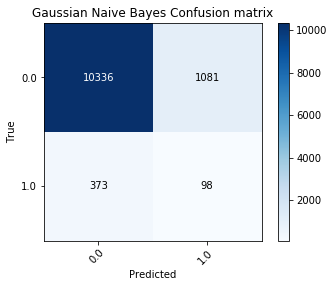

In [63]:
# plot comfusion matrix

fig, ax = plt.subplots()
im = ax.imshow(confusion_gnb, interpolation='nearest',cmap="Blues")
ax.figure.colorbar(im, ax=ax)
classes = unique_labels(y_predict_gnb,y_test)
ax.set(xticks=np.arange(confusion_gnb.shape[1]),yticks=np.arange(confusion_gnb.shape[0]),
       xticklabels=classes, yticklabels=classes, title='Gaussian Naive Bayes Confusion matrix', 
       ylabel='True',xlabel='Predicted')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = confusion_gnb.max() / 2
for i in range(confusion_gnb.shape[0]):
        for j in range(confusion_gnb.shape[1]):
            ax.text(j, i, format(confusion_gnb[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_gnb[i, j] > thresh else "black")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

#### ROC Curve and AUC

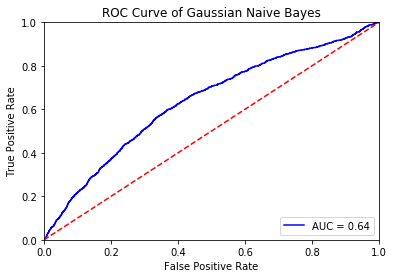

In [59]:
y_scores_gnb = gnb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_gnb[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Gaussian Naive Bayes')
plt.show()

#### Precision-recall curve

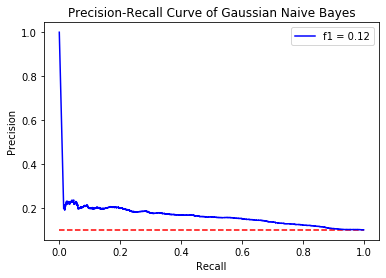

In [61]:
precision_gnb, recall_gnb, _ = precision_recall_curve(y_test, y_scores_gnb[:, 1])
f1_gnb, auc_gnb = f1_score(y_test, y_predict_gnb), auc(recall_gnb, precision_gnb)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall_gnb, precision_gnb,c='b',label = 'f1 = %0.2f' % f1_gnb)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve of Gaussian Naive Bayes')
# show the plot
plt.show()

### Desicision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

#### Search for Optimized Parameters

In [68]:
# train the tree model

param_grid_tree = {'max_depth': np.arange(3, 10)}

tree = DecisionTreeClassifier()
tree_cv=GridSearchCV(tree,param_grid_tree,cv=5)
tree_cv.fit(X_train,y_train)
print(tree_cv.best_params_,tree_cv.best_score_)

{'max_depth': 3} 0.9008580286970942


In [69]:
# The best Parameters is max_depth =3 

In [91]:
%%time
#Train model with optimized parameter
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train,y_train)

CPU times: user 268 ms, sys: 4.5 ms, total: 273 ms
Wall time: 272 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
# Predict the test data
y_predict_tree = tree.predict(X_test)

#### Accuracy Score

In [73]:
tree_score=accuracy_score(y_test,y_predict_tree)
print(tree_score)

0.9008243606998654


#### Confusion metrics

In [74]:
confusion_tree=confusion_matrix(y_predict_tree,y_test)
classifiction_tree=classification_report(y_predict_tree,y_test)

print('Confusion matrix:\n',confusion_tree)
print('Classifiction report:\n',classifiction_tree)

Confusion matrix:
 [[10709  1179]
 [    0     0]]
Classifiction report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     11888
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90     11888
   macro avg       0.50      0.45      0.47     11888
weighted avg       1.00      0.90      0.95     11888



/Users/elisechen/anaconda3/envs/snowfakes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


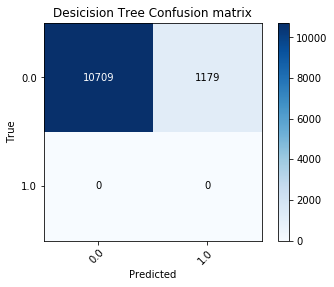

In [75]:
# plot comfusion matrix

fig, ax = plt.subplots()
im = ax.imshow(confusion_tree, interpolation='nearest',cmap="Blues")
ax.figure.colorbar(im, ax=ax)
classes = unique_labels(y_predict_tree,y_test)
ax.set(xticks=np.arange(confusion_tree.shape[1]),yticks=np.arange(confusion_tree.shape[0]),
       xticklabels=classes, yticklabels=classes, title='Desicision Tree Confusion matrix', 
       ylabel='True',xlabel='Predicted')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = confusion_tree.max() / 2
for i in range(confusion_tree.shape[0]):
        for j in range(confusion_tree.shape[1]):
            ax.text(j, i, format(confusion_tree[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_tree[i, j] > thresh else "black")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

#### ROC Curve and AUC

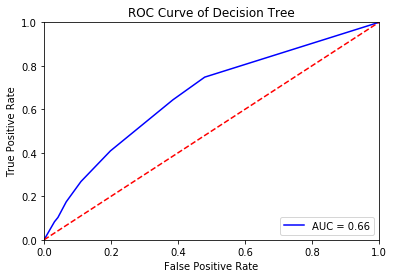

In [76]:
y_scores_tree = tree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_tree[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

#### Precision-Recall Curve

/Users/elisechen/anaconda3/envs/snowfakes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


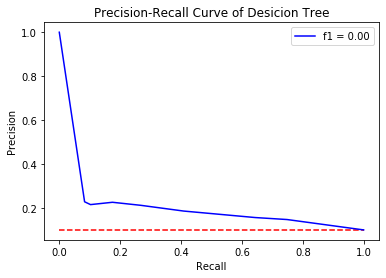

In [77]:
precision_tree, recall_tree, _ = precision_recall_curve(y_test, y_scores_tree[:, 1])
f1_tree, auc_tree = f1_score(y_test, y_predict_tree), auc(recall_tree, precision_tree)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall_tree, precision_tree,c='b',label = 'f1 = %0.2f' % f1_tree)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve of Desicion Tree')
# show the plot
plt.show()

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

#### Search for optimized paramaters

In [62]:
#train RandomForest Model
estimators=[10,100,300,500,800,1000]
criterions=['gini','entropy']
grid_param_rf={'n_estimators':estimators,'criterion':criterions,'bootstrap':[True,False]}
rf=RandomForestClassifier()
rf_cv=GridSearchCV(rf,grid_param_rf,cv=5)
rf_cv.fit(X_train,y_train)

print(rf_cv.best_params_,rf_cv.best_score_)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 500} 0.9007859254452376


In [79]:
# The optimized parameter is bootstrap=True, criterion = gini, n_estimators =500 

In [11]:
%%time
# Train the model with optimized parameter

rf=RandomForestClassifier(bootstrap=True, criterion = 'gini', n_estimators =500)
rf.fit(X_train,y_train)

CPU times: user 57.9 s, sys: 201 ms, total: 58.1 s
Wall time: 58.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
#Predict the test data
y_predict_rf = rf.predict(X_test)

#### Accurate Score

In [87]:
rf_score=accuracy_score(y_test,y_predict_rf)
print(rf_score)

0.9005720053835801


#### Confusion Metrics

In [92]:
confusion_rf=confusion_matrix(y_predict_rf,y_test)
classifiction_rf=classification_report(y_predict_rf,y_test)

print('Confusion matrix:\n',confusion_rf)
print('Classifiction report:\n',classifiction_rf)

Confusion matrix:
 [[10703  1176]
 [    6     3]]
Classifiction report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     11879
         1.0       0.00      0.33      0.01         9

    accuracy                           0.90     11888
   macro avg       0.50      0.62      0.48     11888
weighted avg       1.00      0.90      0.95     11888



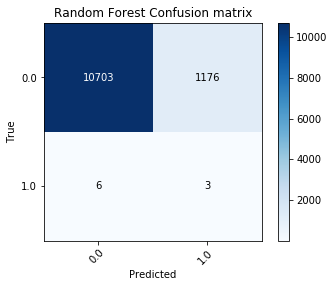

In [93]:
# plot comfusion matrix

fig, ax = plt.subplots()
im = ax.imshow(confusion_rf, interpolation='nearest',cmap="Blues")
ax.figure.colorbar(im, ax=ax)
classes = unique_labels(y_predict_rf,y_test)
ax.set(xticks=np.arange(confusion_rf.shape[1]),yticks=np.arange(confusion_rf.shape[0]),
       xticklabels=classes, yticklabels=classes, title='Random Forest Confusion matrix', 
       ylabel='True',xlabel='Predicted')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = confusion_rf.max() / 2
for i in range(confusion_rf.shape[0]):
        for j in range(confusion_rf.shape[1]):
            ax.text(j, i, format(confusion_rf[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_rf[i, j] > thresh else "black")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

#### ROC Cruve and AUC

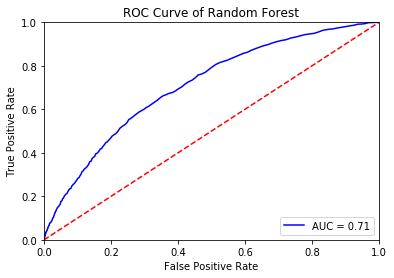

In [94]:
y_scores_rf = rf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_rf[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

#### Precision-recall Curve

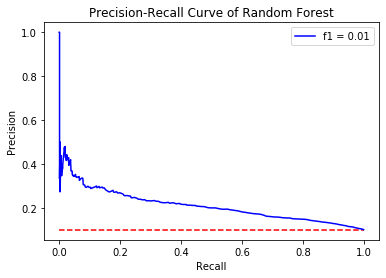

In [95]:
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf[:, 1])
f1_rf, auc_rf = f1_score(y_test, y_predict_rf), auc(recall_rf, precision_rf)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall_rf, precision_rf,c='b',label = 'f1 = %0.2f' % f1_rf)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve of Random Forest')
# show the plot
plt.show()

### Support Vector Machine

In [15]:
from sklearn.svm import SVC

#### Search for optimized parameter

In [ ]:
#train SVM model
Cs=[0.1,1,10]
gammas=[0.01,0.1,1]
kernels=['linear', 'poly', 'rbf', 'sigmoid']
param_grid_svc={'C':Cs,'kernel':kernels,'gamma':gammas}
svc=SVC()
svc_cv=GridSearchCV(svc,param_grid_svc,cv=5)
svc_cv.fit(X_train,y_train)

print(svc_cv.best_params_,svc_cv.best_score_)

In [42]:
%%time
# Train the model with optimized parameter

svm=SVC(C=0.1, gamma=0.01, kernel='rbf',probability=True)
svm.fit(X_train,y_train)

CPU times: user 21min 58s, sys: 5.96 s, total: 22min 4s
Wall time: 22min 34s


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [43]:
%%time
#Predict the test dataset
y_predict_svm = svm.predict(X_test)

CPU times: user 22.1 s, sys: 247 ms, total: 22.3 s
Wall time: 26.6 s


#### Accuracy  Score

In [44]:
svm_score=accuracy_score(y_test,y_predict_svm)
print(svm_score)

0.9008243606998654


#### Confusion Metrics

In [45]:
confusion_svm=confusion_matrix(y_predict_svm,y_test)
classifiction_svm=classification_report(y_predict_svm,y_test)

print('Confusion matrix:\n',confusion_svm)
print('Classifiction report:\n',classifiction_svm)

Confusion matrix:
 [[10709  1179]
 [    0     0]]
Classifiction report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     11888
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90     11888
   macro avg       0.50      0.45      0.47     11888
weighted avg       1.00      0.90      0.95     11888



/Users/elisechen/anaconda3/envs/snowfakes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


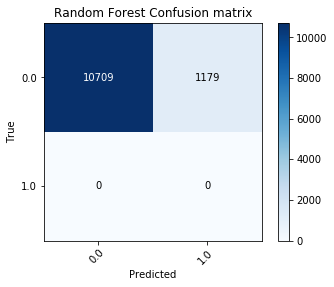

In [46]:
# plot comfusion matrix

fig, ax = plt.subplots()
im = ax.imshow(confusion_svm, interpolation='nearest',cmap="Blues")
ax.figure.colorbar(im, ax=ax)
classes = unique_labels(y_predict_svm,y_test)
ax.set(xticks=np.arange(confusion_svm.shape[1]),yticks=np.arange(confusion_svm.shape[0]),
       xticklabels=classes, yticklabels=classes, title='Random Forest Confusion matrix', 
       ylabel='True',xlabel='Predicted')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = confusion_svm.max() / 2
for i in range(confusion_svm.shape[0]):
        for j in range(confusion_svm.shape[1]):
            ax.text(j, i, format(confusion_svm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_svm[i, j] > thresh else "black")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

#### ROC Curve and AUC curve

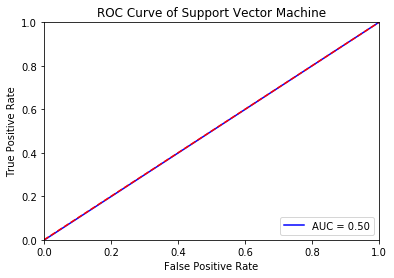

In [47]:
y_scores_svm = svm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores_svm[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Support Vector Machine')
plt.show()

#### Precision-recall Curve

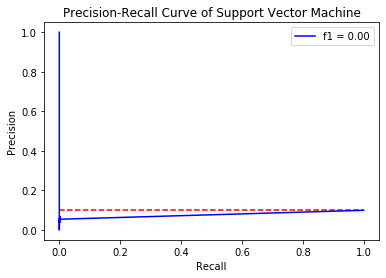

In [50]:
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_scores_svm[:, 1])
f1_svm, auc_svm = f1_score(y_test, y_predict_svm), auc(recall_svm, precision_svm)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall_svm, precision_svm,c='b',label = 'f1 = %0.2f' % f1_svm)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve of Support Vector Machine')
# show the plot
plt.show()

### Random Forest Feature Importance

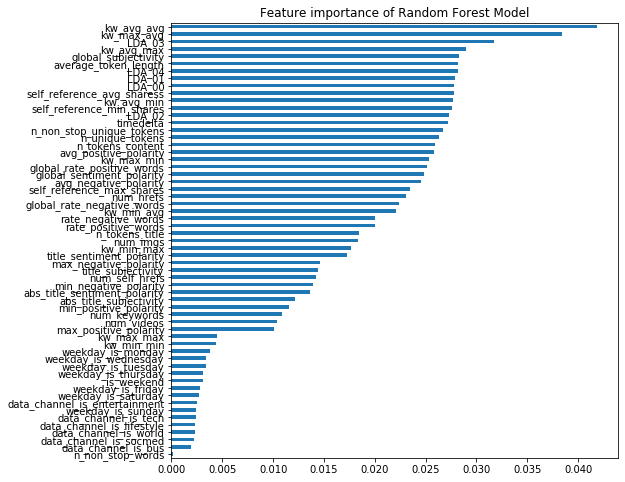

In [97]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

importances.plot(kind='barh',figsize=(8,8))
plt.title("Feature importance of Random Forest Model")
plt.show()